<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/3_0_modeling_regression_DSBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

This lecture is taken from the [5-day JADS NHS PROMs data science case study](https://github.com/jads-nl/execute-nhs-proms/blob/master/README.md). 

In the previous lectures we have worked on data understanding and data preparation. A brief recap:

  - The outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
  - Research has shown that an improvement in OKS score of approx. 30% is clinically relevant ([van der Wees 2017](https://github.com/jads-nl/execute-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
  - To account for ceiling effect, a high final `t1_oks_score` is also considered as a 'good' outcome (even when `delta_oks_score` is smaller than 14)

# Learning objectives

The main objective in this lecture is to learn how to build and interpret a range of commonly applied machine learning algorithms. We will look at the following algorithms:
- (Logistic) Regression
- LASSO
- K-nearest neighbors

To get experience with both numeric and categorical outcome measures, we apply the models in this notebook to try to predict the numeric outcome `t1_eq_vas`. The models applied in the next notebook will try to predict a categorical outcome.



### References used: 

The techniques applied in this notebook are explained in more detail in the following sources: 

#### Python: Hands-on Machine Learning (2nd edition)

- [End-to-end Machine Learning project (chapter 2)](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)
- [Training linear models (chapter 4)](https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb)


#### scikit-learn
- [Tutorial cross validation score](https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html?highlight=cross%20validation%20score)

# Importing data and settings

As always, we start with importing the relevant modules, define some settings (mostly related to how output is depicted) and load the data.

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# constants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

We apply stratified shuffle split, which ensures a similar distribution of our outcome measure in both the training and the test set. This requires that we specify the outcome measure (which should have a similar distribution in the train and test data), and that this outcome measure contains no missing data.

The code below imputes the missings (value 999) with the median, and divides the outcome measure in 10 deciles, which are then used to create the desired split.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

# replacing the sentinal value 999 with the median
df["t1_eq_vas_impute"] = df.t1_eq_vas.replace(
    to_replace=999, value=np.median(df.t1_eq_vas)
)

# add t1_eq_vas deciles
df['t1_eq_vas_cat'] = pd.cut(df.t1_eq_vas_impute, 10)

# introducing 1 split, to set aside 30% (0.30) of the data as test data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['t1_eq_vas_cat']):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

# remove the extra columns, so we continue working with the original dataset
for set_ in (df_train, df_test):
    set_.drop(["t1_eq_vas_impute", "t1_eq_vas_cat"], axis=1, inplace=True)

# Data preparation in a scikit-learn Pipeline

When preparing data such that it can be used for modeling, we have to set up the process such that:

* Information from the test set is not used, as this makes model performance unreliable (known as data leakage);

* It is easy to try out different choices of preparing the data, such as applying pre-processing through a [parameter search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

To this purpose, the [`ColumnTransformer` class](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer) is available in scikit-learn, which is applied in the notebook below.



## Using ColumnsTransformers and Pipelines

As in the notebook on data preparation, we want to perform preprocessing steps on (groups of) columns. In case a feature requires more than one preprocessing step, the use of `Pipeline` is recommended.

### Encoding categorical variables using `OneHotEncoding`
Categorical variables are often best expressed as dummy variables. OneHotEncoder appropriately transforms each categorical feature with n levels into n binary features, with one of these features set to 1, and all others to 0 for every single observation.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# define variable groups, to enhance readability 
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]

# create a group for the dummy variables
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]

# create a group for the five questions that make up the EQ5D
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]

# create a group for all OKS questions
oks_questions = [
    col for col in df.columns if col.startswith("oks_t0") and not col.endswith("_score")
]
oks_score = ["oks_t0_score"]

# define preprocessing pipelines for age and gender columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)

gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                   ('onehot', OneHotEncoder()),
    ]
)


# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        SimpleImputer(missing_values=9, strategy="constant", fill_value=0),
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        oks_questions,
    ),
    "oks_score": (
        "oks_score",
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        oks_score,
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(transformers=[v for _, v in transformers.items()])

X_train = prep.fit_transform(df_train)
X_test = prep.transform(df_test)

In [8]:
# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
X_columns = pd.Series(
    age_band
    + prep.named_transformers_["gender"]["onehot"].get_feature_names().tolist()
    + comorb
    + boolean
    + eq5d
    + categorical
    + oks_questions
    + oks_score
    + eq_vas
)

The output below shows how the data has been prepared using OneHotEncoding (and imputing missings)

In [9]:
pd.DataFrame(data = X_train, columns = X_columns).head(5)

,age_band,x0_1.0,x0_2.0,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,t0_assisted,t0_previous_surgery,t0_disability,t0_mobility,t0_self_care,t0_activity,t0_discomfort,t0_anxiety,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t0_eq_vas
0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,4.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,3.0,2.0,2.0,18.0,90.0
1,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,18.0,85.0
2,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,2.0,3.0,3.0,1.0,2.0,0.0,1.0,1.0,3.0,3.0,2.0,21.0,87.0
3,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,4.0,4.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,23.0,90.0
4,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,4.0,2.0,1.0,1.0,0.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,3.0,23.0,50.0


# Modeling

## Regression

A first step is trying to predict t1_eq_vas. Naturally, we expect t0_eq_vas to be an important predictor. To check our expectations we can first plot the relation between these variables:

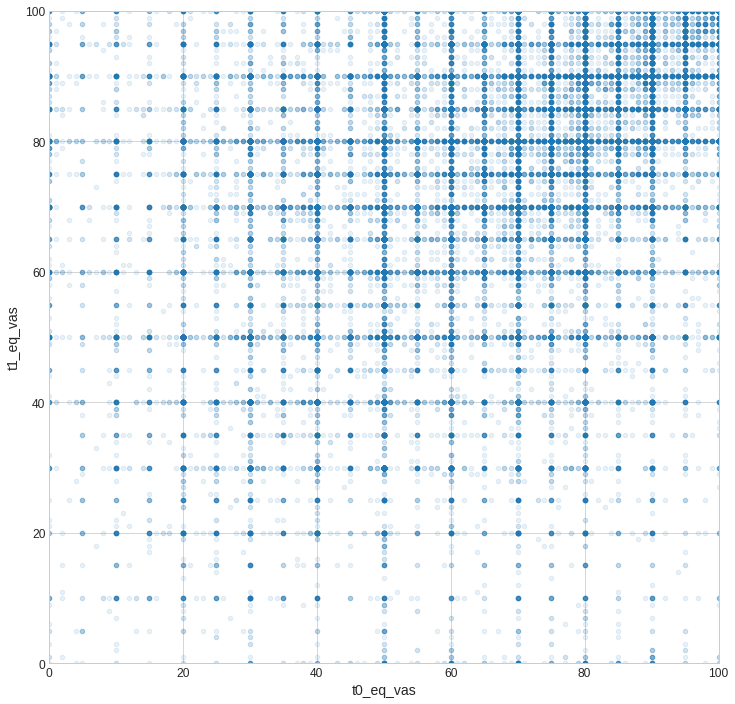

In [10]:
df_train.plot(kind='scatter', x='t0_eq_vas', y='t1_eq_vas', xlim=(0,100), ylim=(0,100), alpha=0.1, figsize=M);

Now we apply a linear regression to see how much of eq_vas at t1 is explained by eq_vas at t0 in a simple (linear) model.

In [12]:
from sklearn.linear_model import LinearRegression

#def fill_median(s):
#    return s.fillna(value=s.median()).to_frame() 

eq = ['t0_eq_vas', 't1_eq_vas']
eq_prep = ColumnTransformer(transformers=
                            [('eq',
                              SimpleImputer(missing_values=999,
                                            strategy='median'),
                              eq),
                            ])
eq_prep.fit(df_train)

# note y = t1_eq
t0_eq, t1_eq = eq_prep.transform(df_train)[:,0].reshape(-1,1), eq_prep.transform(df_train)[:,1]

# prepare t1_eq_test for use in model assessment
t1_eq_test = eq_prep.transform(df_test)[:,1]

# simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(t0_eq, t1_eq)
print('Intercept: ' + str(lin_reg.intercept_))
print('Beta: ' + str(lin_reg.coef_))
print('R2: ' + str(lin_reg.score(t0_eq, t1_eq)))

Intercept: 53.96785070807591
Beta: [0.3119393]
R2: 0.11759546401482956


So this very first, basic model yields an $R^2$ of 0.12 which is very modest. 

We normally should add **cross-validation** to our model building process, to be able to properly compare different model options in terms of performance. 

Next to the choices you have on how to build your models, you also have choices to make regarding the performance metric, being the 'thing' that your model will optimize. Let's apply Mean Squared Error (MSE) as our metric in the next iteration:

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")

scores = cross_val_score(lin_reg, t0_eq, t1_eq, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [16.66593682 16.82464722 16.87729003 16.88592997 16.93669798]
Mean: 16.8381
Standard deviation: 0.0931


The reported root of the MSE of around 16.8 tells us that when a prediction is made, the true outcome is likely to be in the interval of 2 * 16.8 below and 2 * 16.8 above the predicted value. This results in a range of around 65 points for an outcome measure ranging from 0 to 100, which is substantial, and confirms a simple linear model will not do the trick. 

Now that we have seen the simplest setup for a linear regression with only one predictor, let's try to find out which features are the best predictors.

### SelectKBest

For regression tasks, you often want to get a first idea which features contain the most information i.e. are the best predictors. There are various techniques to answer this question, such as stepwise selection. Scikit-learn has various [univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) methods for this purpose. We will use [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).


In [14]:
from sklearn.feature_selection import SelectKBest, f_regression

k10best = Pipeline(
    steps=[
        ("prep", ColumnTransformer(transformers=transformers.values())),
        ("kbest", SelectKBest(f_regression, k=10)),
#         ("lin_reg", LinearRegression())
    ]
)

X_10best = k10best.fit(df_train, t1_eq).transform(df_train)
lin_10best = LinearRegression()
scores_10best = cross_val_score(lin_10best, X_10best, t1_eq, scoring='neg_mean_squared_error', cv=5)
lin_10best_rmse_scores = np.sqrt(-scores_10best)
display_scores(lin_10best_rmse_scores)

Scores: [15.99162775 16.14324365 16.17794808 16.22819153 16.19174312]
Mean: 16.1466
Standard deviation: 0.0821


Using the 10 Best features, the model performs only slightly better with an RMSE of 16.1 +/- 0.08

In [15]:
# show features in descending order of importance
pd.concat(
        {"score": pd.Series(k10best["kbest"].scores_), "feature": X_columns}, axis=1
    ).sort_values("score", ascending=False)


,score,feature
39,12988.61,t0_eq_vas
38,8612.77,oks_t0_score
36,8036.19,oks_t0_shopping
19,7386.24,t0_self_care
17,6930.16,t0_disability
28,6620.98,oks_t0_washing
22,6559.51,t0_anxiety
37,5421.20,oks_t0_stairs
34,5213.64,oks_t0_work
29,4438.80,oks_t0_transport


It is important to realize that linear regression is simply to be used as a baseline model; do not put too much effort into tuning; mainly use it to increase your understanding of the data and as a means of face validity, i.e. to see if there is nothing striking in the importance ranking, which could be indicative of errors in your data, in your data preparation or in your modeling approach. 


So even though you are in the CRISP-DM Modeling phase at this point, approach building a baseline model as helping you to increase your Data Understanding. This is exactly why it is important to not only estimate your baseline model and its performance, but also to describe it from different angles, by showing features in descending order of importance, but also by looking into the coefficients for each feature and their signs (i.e. whether they contribute to higher of lower outcomes).

In [16]:
# build a model with the 10 features, with the purpose to check 
# feature coefficients for face validity

# create pd DataFrame
cols = k10best['kbest'].get_support(indices=True)
X_set = pd.DataFrame(X_10best, columns=X_columns[cols])
X_set.head(10)

,t0_disability,t0_self_care,t0_anxiety,oks_t0_washing,oks_t0_transport,oks_t0_work,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t0_eq_vas
0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,18.0,90.0
1,2.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,18.0,85.0
2,2.0,1.0,1.0,3.0,3.0,1.0,3.0,2.0,21.0,87.0
3,1.0,1.0,1.0,4.0,2.0,2.0,2.0,2.0,23.0,90.0
4,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,23.0,50.0
5,2.0,1.0,1.0,3.0,2.0,2.0,3.0,1.0,19.0,55.0
6,1.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,18.0,95.0
7,1.0,1.0,1.0,3.0,2.0,1.0,3.0,2.0,19.0,70.0
8,2.0,1.0,1.0,4.0,3.0,2.0,3.0,2.0,24.0,95.0
9,2.0,1.0,2.0,4.0,2.0,1.0,2.0,3.0,19.0,40.0


In [17]:
# run model and extract coefficients
lin_reg_full = LinearRegression()
lin_reg_full.fit(X_set, t1_eq)
pd.DataFrame(lin_reg_full.coef_, X_columns[cols], columns=['Coefficients'])

,Coefficients
t0_disability,4.10
t0_self_care,-3.03
t0_anxiety,-3.21
oks_t0_washing,0.88
oks_t0_transport,0.15
oks_t0_work,0.39
oks_t0_shopping,1.12
oks_t0_stairs,0.51
oks_t0_score,-0.06
t0_eq_vas,0.20


The large coefficients with contrasting signs for variables containing information that is 'pointing in the same direction' (disability / self care / anxiety) indicates that there might be multicollinearity, that might introduce some model instability (as indicated by the large, contrasting coefficients). 

## LASSO Regression

We now start looking into other types of models and start with Lasso regression, which is a so-called regularized version of a normal regression. We apply Lasso here using cross-validation (following the example from [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py)), which is now crucial as we have a hyperparameter to tune. Recall that Lasso contains an additional cost component:

$$ J(\Theta) = MSE (\Theta) + \alpha\sum\limits_{i=1}^n \mid{\Theta_{i}}\mid$$

By default `LassoCV` tries 100 different values for $\alpha$. 

We can then easily plot the MSE for all considered $\alpha$ values:

In [21]:
from sklearn.linear_model import LassoCV

EPSILON = 1e-4 # This is to avoid errors in the performance metric

lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train, t1_eq)

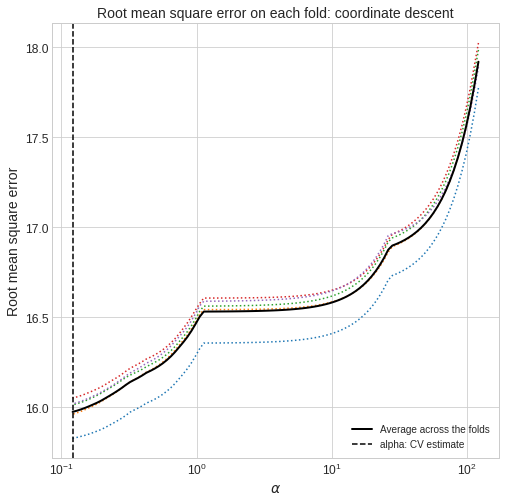

In [22]:
plt.figure(figsize=S)
plt.semilogx(lasso.alphas_ + EPSILON, np.sqrt(lasso.mse_path_), ":")
plt.plot(
    lasso.alphas_ + EPSILON,
    np.sqrt(lasso.mse_path_.mean(axis=-1)),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel("Root mean square error")
plt.title("Root mean square error on each fold: coordinate descent")
plt.axis("tight");

The Lasso model performs best for low $\alpha$ values. Below we can see how much that results in beta coefficients being pushed to zero.

In [23]:
print("Best Lasso model:\n"
      f"  RMSE: {np.sqrt(mean_squared_error(lasso.predict(X_train), t1_eq)):.2f}\n"
      f"  alpha: {lasso.alpha_:.2f}")

Best Lasso model:
  RMSE: 15.97
  alpha: 0.12


By ranking the (absolute) regression coefficients from high to low, we can find the excluded variables (due to the LASSO penalty) at the bottom of the list:

In [24]:
pd.concat({'coef_abs': pd.Series(abs(lasso.coef_)), 'coef': pd.Series(lasso.coef_), 'feature': X_columns}, axis=1).sort_values('coef_abs', ascending=False)

,coef_abs,coef,feature
17,3.57,3.57,t0_disability
13,2.99,-2.99,depression
19,2.34,-2.34,t0_self_care
22,2.21,-2.21,t0_anxiety
7,2.06,-2.06,lung_disease
3,1.77,-1.77,heart_disease
6,1.46,-1.46,circulation
8,1.32,-1.32,diabetes
32,1.07,-1.07,oks_t0_limping
36,0.74,0.74,oks_t0_shopping


True assessment of model performance is not done by looking at the performance on the train set, but by evaluating its performance on the test set. The code below compares the performance on both the train and the test set.

In [25]:
# final test
print(f"MSE from training with CV: {np.sqrt(mean_squared_error(lasso.predict(X_train), t1_eq)):.2f}\n"
      f"MSE test: {np.sqrt(mean_squared_error(lasso.predict(X_test), t1_eq_test)):.2f}")

MSE from training with CV: 15.97
MSE test: 15.98


As the performance is very similar in both data sets, we see that the model was not overfitting the training data, and performance on the training set was thereore not an overly optimistic estimate. The model generalizes well to new (test) data, and we can be confident that the developed model has not been modeling noise / particularities in the data set, but rather contains structural / true relations between input and output.

## KNN

The next algorithm we apply is K nearest neighbor, which makes its prediction for a patient based on the outcomes for the K most comparable patients. This algorithm again has a tuning parameter / hyperparameter (K; indicating the number of most comparable patients to consider) that needs to be tuned using cross-validation.

There are other hyperparameters to consider, such as how to determine the comparability between instances, and whether to weigh comparable instances with regards to how comparable they are. 

In the example below, we only focus on the hyperparameter K.

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from collections import defaultdict

n_neighbors = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300]
knn = defaultdict(dict) # use defaultdict for nested dicts
for n in n_neighbors:
    knn[n]["model"] = KNeighborsRegressor(n_neighbors=n, n_jobs=-1).fit(X_train, t1_eq)
    knn[n]["cross validation scores"] = cross_val_score(
        knn[n]["model"], X_train, t1_eq, scoring="neg_mean_squared_error", cv=5
    )

As we always do when tuning hyperparameters, we plot the model performance for different settings of the hyperparameter:

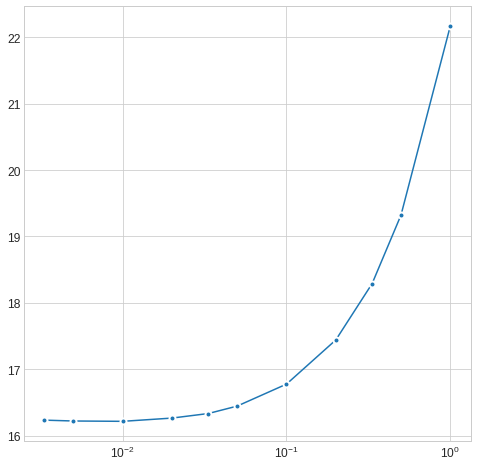

In [32]:
# plot 1/K vs. error rate (such that the X-axis goes from low to high flexibility)
knn_rmse = [np.sqrt(np.mean(-knn[n]['cross validation scores'])) for n in n_neighbors]
plt.figure(figsize=S)
plt.semilogx([1/n for n in n_neighbors], knn_rmse, 'o-', markeredgecolor='w', markeredgewidth='2');

The lowest (best) RMSE is around 16.2, which is attained at 1/K = 10-2, i.e. K=100, so when basing the prediction on the outcomes of the 100 most comparable patients.

In [33]:
knn_rmse

[22.1679462806631,
 19.321915091710387,
 18.29123839770176,
 17.442539157673334,
 16.77770182139477,
 16.447074958434087,
 16.33515225308023,
 16.26667231933237,
 16.217699290672076,
 16.222726007472602,
 16.235663104861707]

Applying our trained model to the test data results in nearly identical performance, indicating that the model generalizes well.

In [34]:
# final test
print(f"{np.sqrt(mean_squared_error(knn[100]['model'].predict(X_test), t1_eq_test)):.4f}")    

16.2498


The performance with KNN is comparable with the performance obtained with linear regression and a linear application of LASSO. We tuned KNN by considering a range of different K values, but we could possibly further improve model performance by selecting fewer features, as KNN is known to suffer greatly from the inclusion of additional features that do have a substantially weaker connection to the outcome variable (the curse of high dimensionality).

In [35]:
print(X_columns[X_columns=='t0_eq_vas'])
print(X_columns[X_columns=='oks_t0_score'])
print(X_columns[X_columns=='t0_self_care'])
print(X_columns[X_columns=='age_band'])
print(X_columns[X_columns=='oks_t0_confidence'])

39    t0_eq_vas
dtype: object
38    oks_t0_score
dtype: object
19    t0_self_care
dtype: object
0    age_band
dtype: object
35    oks_t0_confidence
dtype: object


In [28]:
subset = X_train[:,[39, 38, 19, 0, 35]]

n_neighbors = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300]
knn = defaultdict(dict) # use defaultdict for nested dicts
for n in n_neighbors:
    knn[n]["model"] = KNeighborsRegressor(n_neighbors=n, n_jobs=-1).fit(subset, t1_eq)
    knn[n]["cross validation scores"] = cross_val_score(
        knn[n]["model"], subset, t1_eq, scoring="neg_mean_squared_error", cv=5
    )

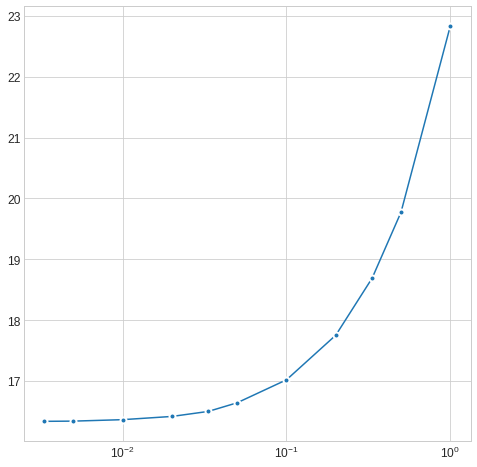

In [29]:
# plot 1/K vs. error rate
knn_rmse = [np.sqrt(np.mean(-knn[n]['cross validation scores'])) for n in n_neighbors]
plt.figure(figsize=S)
plt.semilogx([1/n for n in n_neighbors], knn_rmse, 'o-', markeredgecolor='w', markeredgewidth='2');

In [30]:
knn_rmse

[22.83461894800053,
 19.773160513020617,
 18.690602897220668,
 17.75292645689211,
 17.019135801501474,
 16.641939253823256,
 16.49976862670865,
 16.417276084315134,
 16.364251692926583,
 16.340213247106327,
 16.336810154782082]

In this case selecting a smaller set of features did not improve model performance, but it did make the model easier and faster to use, as it requires less input. Be aware that building models is not only about optimizing performance, but that tradeoffs come into play regarding interpretability and ease of use.

# Summary

We considered three basic machine learning algorithms:
- Regression
- LASSO
- KNN

and applied them for modeling a numeric outcome. LASSO and KNN both used a hyperparameter and therefore needed to be tuned using cross-validation, which allowed us to compare performance for all possible hyperparameter settings. Regression is often used at the start, simply to quickly generate a baseline model. 

Quickly working towards a baseline model is a good practice, as it forces you to set up your full pipeline, and in such a way that it can be tweaked relatively easily.

A strategy for quickly getting started, would be to: 
- Run a regression to get baseline performance and check your results for face validity
- Run LASSO and compare performance
- With the selected variables in your LASSO, run KNN and compare performance

The next notebook will look at more sophisticated machine learning algorithms that tend to perform better than the models considered in this notebook. In that notebook, a binary outcome instead of a numeric outcome will be modeled. 
